In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/datalawyer')
path_results = Path('/opt/models/elmo/ner/results_datalawyer_jur_embeddings_com_lower_ner_com_lower/')
#path_results = Path('/opt/models/elmo/ner/results_datalawyer_jur/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/opt/models/elmo/ner/results_datalawyer_jur_embeddings_com_lower_ner_com_lower/datalawyer


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    if folder.is_dir():
        results_model_folder = folder.iterdir()
        for training_folder in results_model_folder:
            #print('Reading files from %s' % training_folder.name)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[training_folder.name] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[training_folder.name] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % training_folder.name)
                del configs[training_folder.name]
print(len(metrics))
print(len(configs))

27
27


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
DOMAN_SPECIFIC = 'Domain_Specific'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, EMBEDDING, DOMAN_SPECIFIC, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Embedding',
 'Domain_Specific',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: False, EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        embedding_type = 'No' if data[1] == 'glove-lc' else data[3]
        domain_specific = data[2] == 'jur'
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: domain_specific, EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        return {MODEL: data[0], EMBEDDING: data[1], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[3], TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    elif len(data) == 7:
        return {MODEL: data[0], EMBEDDING: data[1] + '-' + data[4], DOMAN_SPECIFIC: True, EMBEDDING_TYPE: data[2], TRAINING_NUMBER: data[5], EXECUTION_NUMBER: data[6]}
    else:
        print('Invalid id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer', 'wang2vec-lc', 'jur', 'cbow', '0', '1']
['datalawyer', 'word2vec-lc', 'jur', 'skip', '0', '2']
['datalawyer', 'fasttext-lc', 'jur', 'cbow', '0', '2']
['datalawyer', 'fasttext-lc', 'jur', 'skip', '0', '0']
['datalawyer', 'glove-lc', 'jur', '0', '2']
['datalawyer', 'word2vec-lc', 'jur', 'cbow', '0', '2']
['datalawyer', 'glove-lc', 'jur', '0', '0']
['datalawyer', 'fasttext-lc', 'jur', 'cbow', '0', '1']
['datalawyer', 'wang2vec-lc', 'jur', 'skip', '0', '2']
['datalawyer', 'word2vec-lc', 'jur', 'skip', '0', '0']
['datalawyer', 'glove-lc', 'jur', '0', '1']
['datalawyer', 'word2vec-lc', 'cbow', 'jur', '5B', '0', '0']
['datalawyer', 'word2vec-lc', 'skip', 'jur', '5B', '0', '2']
['datalawyer', 'wang2vec-lc', 'jur', 'skip', '0', '1']
['datalawyer', 'word2vec-lc', 'cbow', 'jur', '5B', '0', '1']
['datalawyer', 'fasttext-lc', 'jur', 'skip', '0', '2']
['datalawyer', 'wang2vec-lc', 'jur', 'cbow', '0', '2']
['datalawyer', 'word2vec-lc', 'skip', 'jur', '5B', '0', '1']
['datalawyer', 'wan

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df

,Training_ID,Model,Embedding,Domain_Specific,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer_wang2vec-lc_jur_cbow_0_1,datalawyer,wang2vec-lc,True,cbow,0,1,17,20,01:23:46,5026.0,251.30,0.996273,0.996419,0.958694,0.958694,0.958694,6.068438,0.989088,0.989421,0.889640,0.892319,0.890977,34.276933,0.986024,0.986499,0.844615,0.860502,0.852484,47.152097
1,datalawyer_word2vec-lc_jur_skip_0_2,datalawyer,word2vec-lc,True,skip,0,2,10,20,01:20:09,4809.0,240.45,0.995962,0.996158,0.953390,0.955102,0.954245,6.709667,0.987996,0.988237,0.880673,0.905873,0.893096,28.905171,0.986692,0.987203,0.838734,0.872257,0.855167,40.103092
2,datalawyer_fasttext-lc_jur_cbow_0_2,datalawyer,fasttext-lc,True,cbow,0,2,14,20,01:24:05,5045.0,252.25,0.992004,0.992343,0.915971,0.912980,0.914473,11.454841,0.987904,0.988366,0.885331,0.895331,0.890303,24.425737,0.985988,0.986657,0.854574,0.856583,0.855577,33.129692
3,datalawyer_fasttext-lc_jur_skip_0_0,datalawyer,fasttext-lc,True,skip,0,0,14,20,01:24:08,5048.0,252.40,0.996381,0.996580,0.958449,0.956571,0.957509,5.943433,0.988385,0.988810,0.876479,0.892319,0.884328,30.377940,0.986499,0.987115,0.842146,0.861285,0.851608,42.248518
4,datalawyer_glove-lc_jur_0_2,datalawyer,glove-lc,True,No,0,2,12,20,01:25:22,5122.0,256.10,0.995685,0.995881,0.950745,0.948571,0.949657,6.985660,0.988958,0.989217,0.884615,0.900602,0.892537,29.904584,0.986217,0.986622,0.848669,0.874608,0.861443,41.055470
5,datalawyer_word2vec-lc_jur_cbow_0_2,datalawyer,word2vec-lc,True,cbow,0,2,15,20,01:22:27,4947.0,247.35,0.993872,0.994148,0.929085,0.928327,0.928706,9.617297,0.988644,0.989014,0.887061,0.893072,0.890056,27.143066,0.987009,0.987537,0.852134,0.876176,0.863988,37.228111
6,datalawyer_glove-lc_jur_0_0,datalawyer,glove-lc,True,No,0,0,16,20,01:27:38,5258.0,262.90,0.995689,0.995881,0.949183,0.948408,0.948795,7.107949,0.987663,0.988144,0.878229,0.896084,0.887067,32.816166,0.986024,0.986587,0.835596,0.868339,0.851653,44.667346
7,datalawyer_fasttext-lc_jur_cbow_0_1,datalawyer,fasttext-lc,True,cbow,0,1,14,20,01:21:03,4863.0,243.15,0.992154,0.992527,0.916817,0.914122,0.915468,11.419282,0.988718,0.989106,0.896813,0.890060,0.893424,23.281309,0.985724,0.986340,0.863924,0.855799,0.859843,30.694326
8,datalawyer_wang2vec-lc_jur_skip_0_2,datalawyer,wang2vec-lc,True,skip,0,2,10,20,01:19:52,4792.0,239.60,0.996154,0.996323,0.953523,0.954612,0.954067,6.184820,0.988200,0.988496,0.874727,0.904367,0.889300,28.121525,0.984668,0.985126,0.825373,0.866771,0.845566,41.224789
9,datalawyer_word2vec-lc_jur_skip_0_0,datalawyer,word2vec-lc,True,skip,0,0,8,20,01:22:00,4920.0,246.00,0.996392,0.996569,0.955715,0.958367,0.957039,6.006365,0.988366,0.988625,0.883445,0.896084,0.889720,28.542755,0.986464,0.986904,0.852446,0.873824,0.863003,39.069059


In [10]:
training_data_df.to_csv('training_data_20_epochs_mestrado_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:23:10.333333'

In [12]:
training_data_df.groupby([EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding_Type,,,,,,,,
cbow,12.0,0.858207,0.004174,0.852194,0.855053,0.858695,0.860797,0.863988
No,3.0,0.857258,0.005048,0.851653,0.855166,0.858679,0.860061,0.861443
skip,12.0,0.855491,0.004673,0.845566,0.853237,0.855151,0.858247,0.863003


In [13]:
training_data_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
word2vec-lc-5B,6.0,0.858986,0.002917,0.855135,0.856994,0.859747,0.859988,0.863142
word2vec-lc,6.0,0.857809,0.004761,0.852194,0.854817,0.856484,0.861703,0.863988
glove-lc,3.0,0.857258,0.005048,0.851653,0.855166,0.858679,0.860061,0.861443
fasttext-lc,6.0,0.856254,0.003836,0.851608,0.853191,0.856305,0.859140,0.861068
wang2vec-lc,6.0,0.854346,0.005900,0.845566,0.852733,0.853498,0.856650,0.863337


In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding      Embedding_Type                                                  
word2vec-lc-5B cbow              3.0  0.860915  0.001940  0.859588  0.859802   
word2vec-lc    cbow              3.0  0.857994  0.005899  0.852194  0.854998   
               skip              3.0  0.857624  0.004665  0.854701  0.854934   
fasttext-lc    cbow              3.0  0.857484  0.002168  0.855577  0.856305   
glove-lc       No                3.0  0.857258  0.005048  0.851653  0.855166   
word2vec-lc-5B skip              3.0  0.857057  0.002518  0.855135  0.855632   
wang2vec-lc    cbow              3.0  0.856433  0.006000  0.852484  0.852981   
fasttext-lc    skip              3.0  0.855024  0.005249  0.851608  0.852002   
wang2vec-lc    skip              3.0  0.852259  0.006161  0.845566  0.849542   

                                    50%       75%       max  
Embedding      Embedding_Type                                
word2vec-lc-5B cbow            0.860015  0.861578  0.863142  
word2vec-lc    cbow            0.857802  0.860895  0.863988  
               skip            0.855167  0.859085  0.863003  
fasttext-lc    cbow            0.857032  0.858437  0.859843  
glove-lc       No              0.858679  0.860061  0.861443  
word2vec-lc-5B skip            0.856129  0.858018  0.859907  
wang2vec-lc    cbow            0.853478  0.858408  0.863337  
fasttext-lc    skip            0.852396  0.856732  0.861068  
wang2vec-lc    skip            0.853518  0.855606  0.857694

In [15]:
training_data_df.groupby([EMBEDDING, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Domain_Specific,,,,,,,,
word2vec-lc-5B,True,6.0,0.858986,0.002917,0.855135,0.856994,0.859747,0.859988,0.863142
word2vec-lc,True,6.0,0.857809,0.004761,0.852194,0.854817,0.856484,0.861703,0.863988
glove-lc,True,3.0,0.857258,0.005048,0.851653,0.855166,0.858679,0.860061,0.861443
fasttext-lc,True,6.0,0.856254,0.003836,0.851608,0.853191,0.856305,0.859140,0.861068
wang2vec-lc,True,6.0,0.854346,0.005900,0.845566,0.852733,0.853498,0.856650,0.863337


In [16]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE, DOMAN_SPECIFIC]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std  \
Embedding      Embedding_Type Domain_Specific                              
word2vec-lc-5B cbow           True               3.0  0.860915  0.001940   
word2vec-lc    cbow           True               3.0  0.857994  0.005899   
               skip           True               3.0  0.857624  0.004665   
fasttext-lc    cbow           True               3.0  0.857484  0.002168   
glove-lc       No             True               3.0  0.857258  0.005048   
word2vec-lc-5B skip           True               3.0  0.857057  0.002518   
wang2vec-lc    cbow           True               3.0  0.856433  0.006000   
fasttext-lc    skip           True               3.0  0.855024  0.005249   
wang2vec-lc    skip           True               3.0  0.852259  0.006161   

                                                    min       25%       50%  \
Embedding      Embedding_Type Domain_Specific                                 
word2vec-lc-5B cbow           True             0.859588  0.859802  0.860015   
word2vec-lc    cbow           True             0.852194  0.854998  0.857802   
               skip           True             0.854701  0.854934  0.855167   
fasttext-lc    cbow           True             0.855577  0.856305  0.857032   
glove-lc       No             True             0.851653  0.855166  0.858679   
word2vec-lc-5B skip           True             0.855135  0.855632  0.856129   
wang2vec-lc    cbow           True             0.852484  0.852981  0.853478   
fasttext-lc    skip           True             0.851608  0.852002  0.852396   
wang2vec-lc    skip           True             0.845566  0.849542  0.853518   

                                                    75%       max  
Embedding      Embedding_Type Domain_Specific                      
word2vec-lc-5B cbow           True             0.861578  0.863142  
word2vec-lc    cbow           True             0.860895  0.863988  
               skip           True             0.859085  0.863003  
fasttext-lc    cbow           True             0.858437  0.859843  
glove-lc       No             True             0.860061  0.861443  
word2vec-lc-5B skip           True             0.858018  0.859907  
wang2vec-lc    cbow           True             0.858408  0.863337  
fasttext-lc    skip           True             0.856732  0.861068  
wang2vec-lc    skip           True             0.855606  0.857694

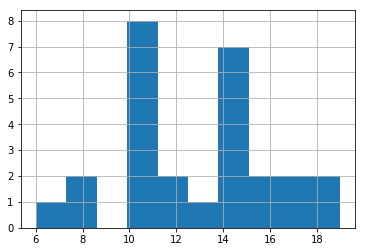

In [17]:
training_data_df[BEST_EPOCH].hist()

In [18]:
training_data_df[TOTAL_DURATION].describe()

count      27.000000
mean     4990.333333
std       116.172286
min      4792.000000
25%      4907.500000
50%      4984.000000
75%      5046.500000
max      5258.000000
Name: Total_Duration(s), dtype: float64

In [19]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,27.0,0.856894,0.004504,0.845566,0.853498,0.857032,0.859961,0.863988


In [20]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,27.0,0.856894,0.004504,0.000867,0.855112,0.858676


In [21]:
rp.summary_cont(training_data_df.groupby(MODEL))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Model,,,,,,
datalawyer,27,0.856894,0.004504,0.000867,0.855195,0.858593


In [22]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
fasttext-lc,6,0.856254,0.003836,0.001566,0.853184,0.859323
glove-lc,3,0.857258,0.005048,0.002914,0.851546,0.862970
wang2vec-lc,6,0.854346,0.005900,0.002409,0.849625,0.859067
word2vec-lc,6,0.857809,0.004761,0.001944,0.854000,0.861618
word2vec-lc-5B,6,0.858986,0.002917,0.001191,0.856652,0.861320


In [23]:
rp.summary_cont(training_data_df.groupby([MODEL,EMBEDDING]))[TEST_F1_MEASURE]

N      Mean        SD        SE  95% Conf.  \
Model      Embedding                                                    
datalawyer fasttext-lc     6  0.856254  0.003836  0.001566   0.853184   
           glove-lc        3  0.857258  0.005048  0.002914   0.851546   
           wang2vec-lc     6  0.854346  0.005900  0.002409   0.849625   
           word2vec-lc     6  0.857809  0.004761  0.001944   0.854000   
           word2vec-lc-5B  6  0.858986  0.002917  0.001191   0.856652   

                           Interval  
Model      Embedding                 
datalawyer fasttext-lc     0.859323  
           glove-lc        0.862970  
           wang2vec-lc     0.859067  
           word2vec-lc     0.861618  
           word2vec-lc-5B  0.861320

In [24]:
print(TEST_F1_MEASURE, MODEL, EMBEDDING, BATCH_SIZE, ELMO_DROPOUT)

Test_F1_Measure Model Embedding Batch_Size ELMo_Dropout


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING)

Overall model F( 4, 22) =  0.885, p =  0.48938652345701005864
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.8845
Date:                Mon, 27 May 2019   Prob (F-statistic):              0.489
Time:                        00:07:58   Log-Likelihood:                 110.08
No. Observations:                  27   AIC:                            -210.2
Df Residuals:                      22   BIC:                            -203.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------